In [2]:
%matplotlib inline

from urllib.request import urlretrieve

import matplotlib.pyplot as plt
import nengo
import tensorflow as tf
import numpy as np
import nengo_dl

seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
def flatten(image, label):
    '''Transform image to the flattened version of itself'''
    flattened = tf.reshape(image, [28*28])
    flattened = tf.expand_dims(flattened, 0)
    return tf.cast(flattened, tf.float32), label

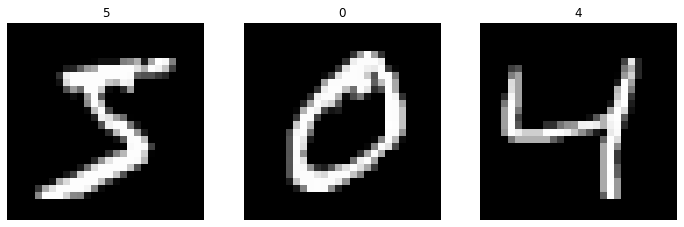

In [15]:
(train_images, train_labels), (test_images,test_labels) = tf.keras.datasets.mnist.load_data()

# flatten images and add time dimension
train_images = train_images.reshape((train_images.shape[0], 1, -1))
train_labels = train_labels.reshape((train_labels.shape[0], 1, -1))
test_images = test_images.reshape((test_images.shape[0], 1, -1))
test_labels = test_labels.reshape((test_labels.shape[0], 1, -1))

plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(np.reshape(train_images[i], (28, 28)), cmap="gray")
    plt.axis("off")
    plt.title(str(train_labels[i, 0, 0]))

In [16]:
# input
inp = tf.keras.Input(shape=(784, ))

dense_1 = tf.keras.layers.Dense(800, activation='relu', input_shape=(784,))(inp)
dense_2 = tf.keras.layers.Dense(10)(dense_1)

model = tf.keras.Model(inputs=inp, outputs=dense_2)

In [19]:
model.get_weights()[0]

array([[-0.03998807, -0.02240583,  0.04376486, ...,  0.03929744,
         0.00358075,  0.03279448],
       [-0.04756851, -0.05482681, -0.05000316, ..., -0.05500342,
         0.00440086,  0.06144325],
       [-0.06137484, -0.02681687, -0.01800681, ..., -0.05508586,
        -0.01022767, -0.01006152],
       ...,
       [-0.04014251, -0.04270911, -0.01107579, ..., -0.00650558,
         0.00865404,  0.05036464],
       [ 0.0077714 ,  0.00266884,  0.03345043, ..., -0.02314425,
         0.03177794, -0.05783299],
       [-0.01206281, -0.00124823,  0.03564489, ..., -0.00332176,
        -0.01387923,  0.01180165]], dtype=float32)

In [20]:
converter = nengo_dl.Converter(model)

In [21]:
converter

In [23]:
do_training = True
if do_training:
    with nengo_dl.Simulator(converter.net, minibatch_size=200) as sim:
        # run training
        sim.compile(
            optimizer=tf.optimizers.Adam(0.001),
            loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=[tf.metrics.sparse_categorical_accuracy],
        )
        sim.fit(
            {converter.inputs[inp]: train_images},
            {converter.outputs[dense]: train_labels},
            validation_data=(
                {converter.inputs[inp]: test_images},
                {converter.outputs[dense]: test_labels},
            ),
            epochs=2,
        )

        # save the parameters to file
        sim.save_params("./keras_to_snn_params")
else:
    # download pretrained weights
    urlretrieve(
        "https://drive.google.com/uc?export=download&"
        "id=1lBkR968AQo__t8sMMeDYGTQpBJZIs2_T",
        "keras_to_snn_params.npz",
    )
    print("Loaded pretrained weights")

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               


/home/viktor/.local/lib/python3.8/site-packages/nengo_dl/simulator.py:460: UserWarning: No GPU support detected. See https://www.nengo.ai/nengo-dl/installation.html#installing-tensorflow for instructions on setting up TensorFlow with GPU support.
  warnings.warn(


KeyError: (<Reference wrapping <tf.Tensor 'dense/BiasAdd:0' shape=(None, 10) dtype=float32>>,)

In [6]:
def run_network(
    activation,
    params_file="keras_to_snn_params",
    n_steps=30,
    scale_firing_rates=1,
    synapse=None,
    n_test=400,
):
    # convert the keras model to a nengo network
    nengo_converter = nengo_dl.Converter(
        model,
        swap_activations={tf.nn.relu: activation},
        scale_firing_rates=scale_firing_rates,
        synapse=synapse,
    )

    # get input/output objects
    nengo_input = nengo_converter.inputs[inp]
    nengo_output = nengo_converter.outputs[dense]

    # add a probe to the first convolutional layer to record activity.
    # we'll only record from a subset of neurons, to save memory.
    sample_neurons = np.linspace(
        0,
        np.prod(conv0.shape[1:]),
        1000,
        endpoint=False,
        dtype=np.int32,
    )
    with nengo_converter.net:
        conv0_probe = nengo.Probe(nengo_converter.layers[conv0][sample_neurons])

    # repeat inputs for some number of timesteps
    tiled_test_images = np.tile(test_images[:n_test], (1, n_steps, 1))

    # set some options to speed up simulation
    with nengo_converter.net:
        nengo_dl.configure_settings(stateful=False)

    # build network, load in trained weights, run inference on test images
    with nengo_dl.Simulator(
        nengo_converter.net, minibatch_size=10, progress_bar=False
    ) as nengo_sim:
        nengo_sim.load_params(params_file)
        data = nengo_sim.predict({nengo_input: tiled_test_images})

    # compute accuracy on test data, using output of network on
    # last timestep
    predictions = np.argmax(data[nengo_output][:, -1], axis=-1)
    accuracy = (predictions == test_labels[:n_test, 0, 0]).mean()
    print(f"Test accuracy: {100 * accuracy:.2f}%")

    # plot the results
    for ii in range(3):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.title("Input image")
        plt.imshow(test_images[ii, 0].reshape((28, 28)), cmap="gray")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        scaled_data = data[conv0_probe][ii] * scale_firing_rates
        if isinstance(activation, nengo.SpikingRectifiedLinear):
            scaled_data *= 0.001
            rates = np.sum(scaled_data, axis=0) / (n_steps * nengo_sim.dt)
            plt.ylabel("Number of spikes")
        else:
            rates = scaled_data
            plt.ylabel("Firing rates (Hz)")
        plt.xlabel("Timestep")
        plt.title(
            f"Neural activities (conv0 mean={rates.mean():.1f} Hz, "
            f"max={rates.max():.1f} Hz)"
        )
        plt.plot(scaled_data)

        plt.subplot(1, 3, 3)
        plt.title("Output predictions")
        plt.plot(tf.nn.softmax(data[nengo_output][ii]))
        plt.legend([str(j) for j in range(10)], loc="upper left")
        plt.xlabel("Timestep")
        plt.ylabel("Probability")

        plt.tight_layout()

/home/viktor/.local/lib/python3.8/site-packages/nengo_dl/simulator.py:460: UserWarning: No GPU support detected. See https://www.nengo.ai/nengo-dl/installation.html#installing-tensorflow for instructions on setting up TensorFlow with GPU support.
  warnings.warn(


Test accuracy: 98.25%


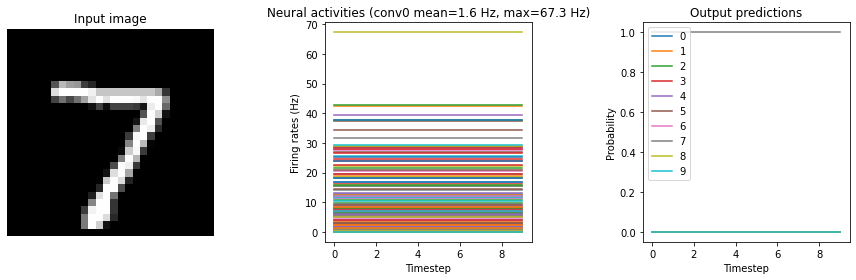

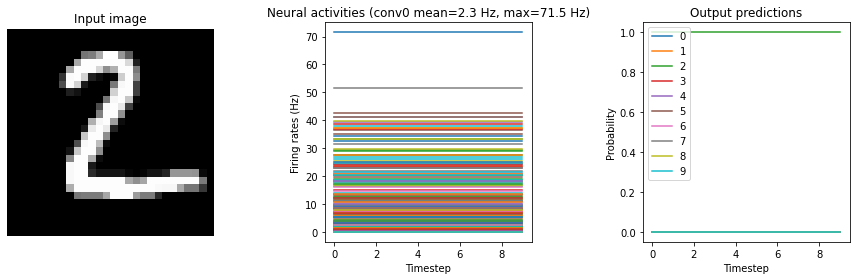

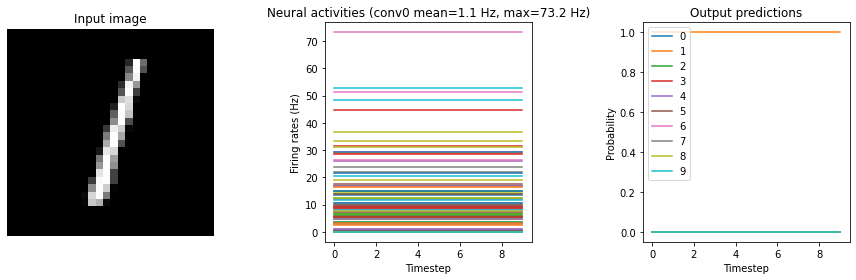

In [7]:
run_network(activation=nengo.RectifiedLinear(), n_steps=10)

/home/viktor/.local/lib/python3.8/site-packages/nengo_dl/simulator.py:460: UserWarning: No GPU support detected. See https://www.nengo.ai/nengo-dl/installation.html#installing-tensorflow for instructions on setting up TensorFlow with GPU support.
  warnings.warn(


Test accuracy: 20.75%


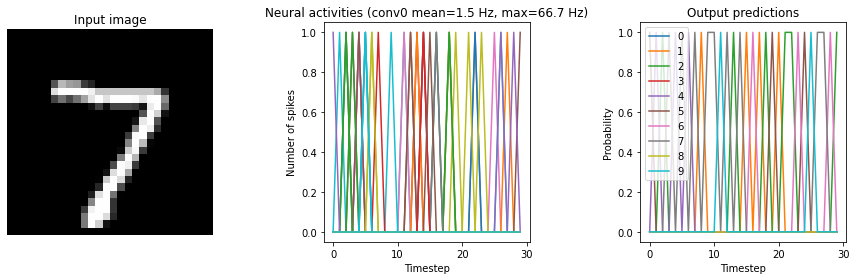

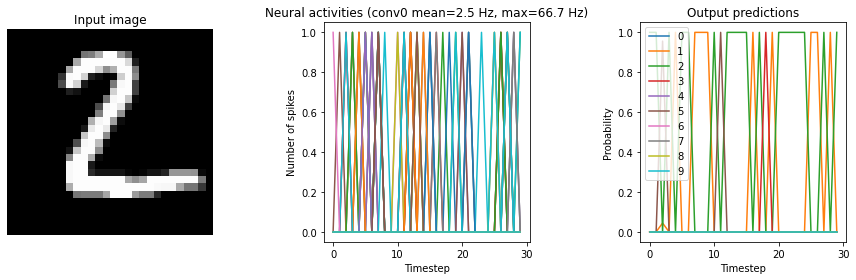

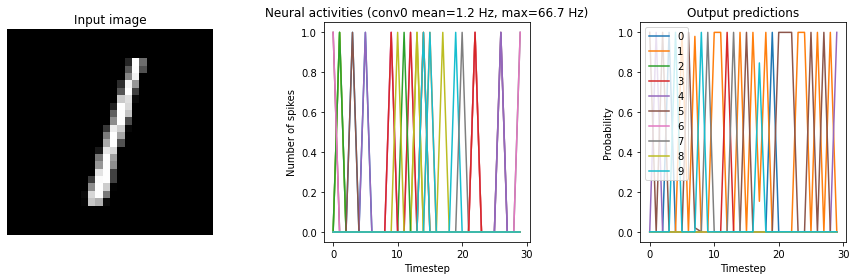

In [8]:
run_network(activation=nengo.SpikingRectifiedLinear())

Synapse=0.001


/home/viktor/.local/lib/python3.8/site-packages/nengo_dl/simulator.py:460: UserWarning: No GPU support detected. See https://www.nengo.ai/nengo-dl/installation.html#installing-tensorflow for instructions on setting up TensorFlow with GPU support.
  warnings.warn(


Test accuracy: 23.00%


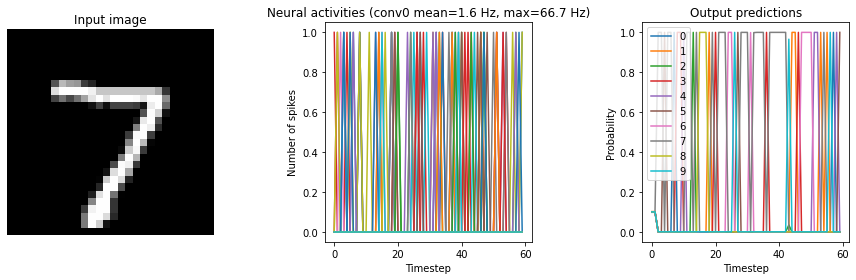

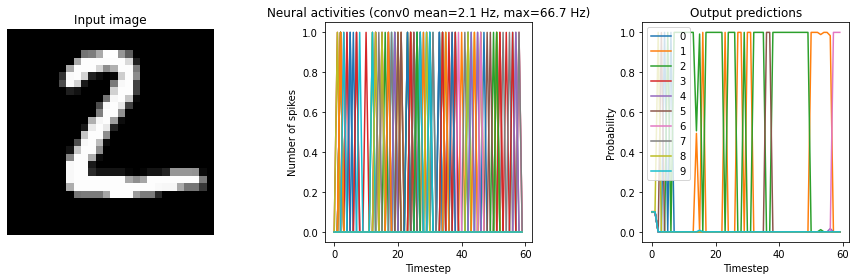

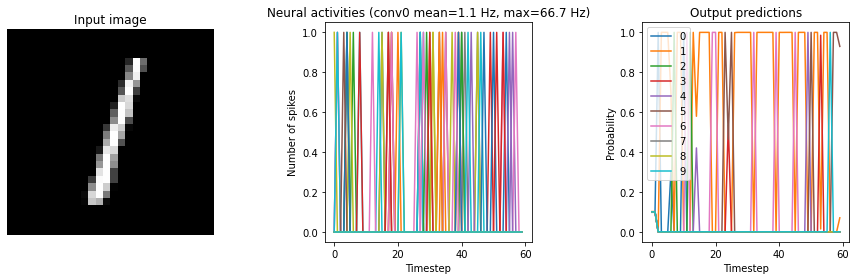

Synapse=0.005


/home/viktor/.local/lib/python3.8/site-packages/nengo_dl/simulator.py:460: UserWarning: No GPU support detected. See https://www.nengo.ai/nengo-dl/installation.html#installing-tensorflow for instructions on setting up TensorFlow with GPU support.
  warnings.warn(


Test accuracy: 52.25%


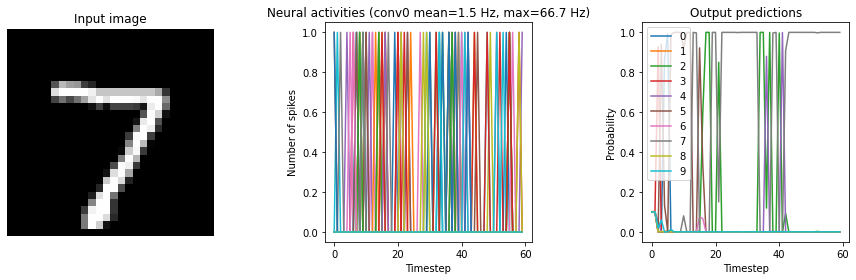

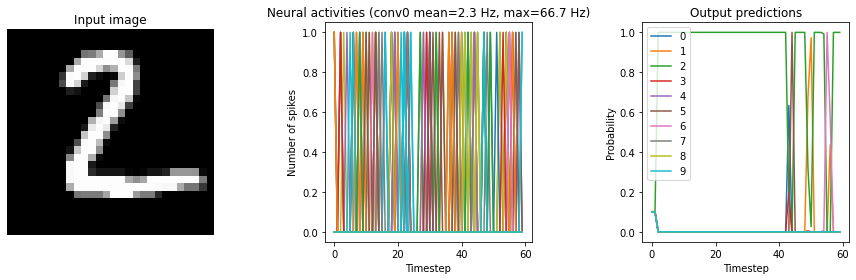

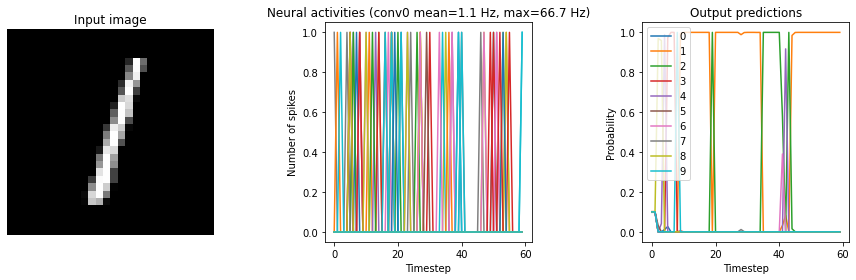

Synapse=0.010


/home/viktor/.local/lib/python3.8/site-packages/nengo_dl/simulator.py:460: UserWarning: No GPU support detected. See https://www.nengo.ai/nengo-dl/installation.html#installing-tensorflow for instructions on setting up TensorFlow with GPU support.
  warnings.warn(


Test accuracy: 71.75%


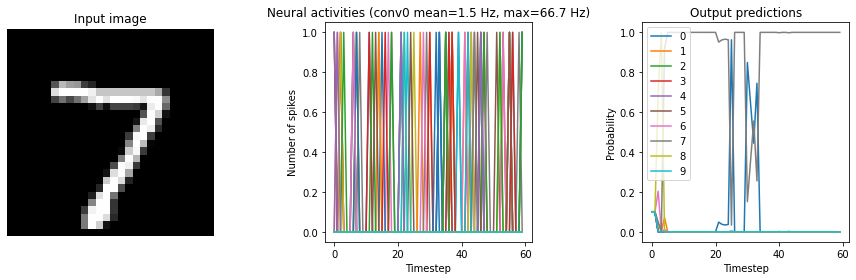

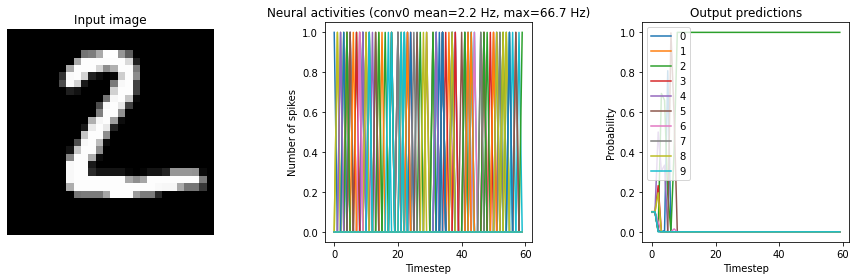

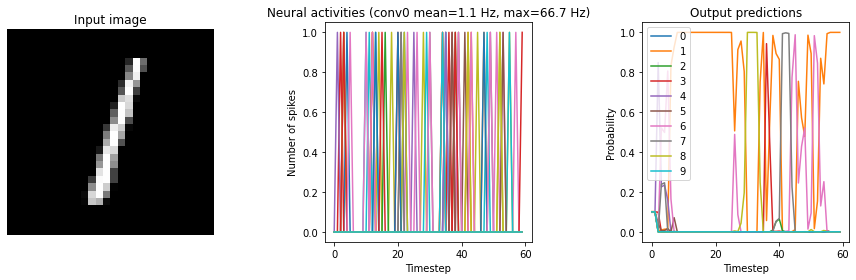

In [9]:
for s in [0.001, 0.005, 0.01]:
    print(f"Synapse={s:.3f}")
    run_network(
        activation=nengo.SpikingRectifiedLinear(),
        n_steps=60,
        synapse=s,
    )
    plt.show()

Scale=2


/home/viktor/.local/lib/python3.8/site-packages/nengo_dl/simulator.py:460: UserWarning: No GPU support detected. See https://www.nengo.ai/nengo-dl/installation.html#installing-tensorflow for instructions on setting up TensorFlow with GPU support.
  warnings.warn(


Test accuracy: 80.25%


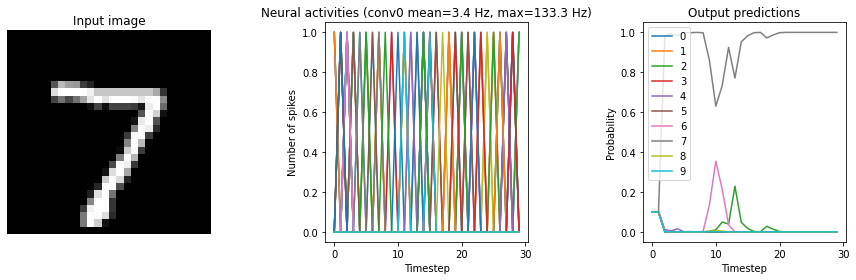

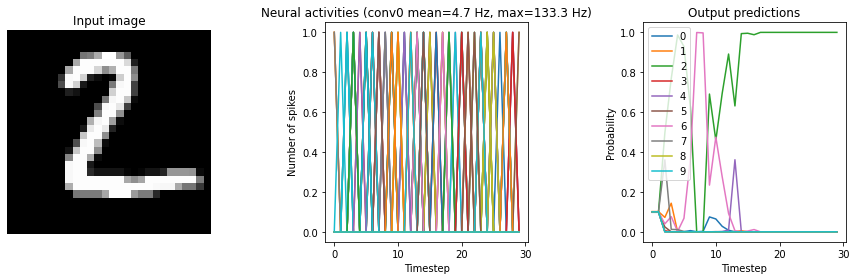

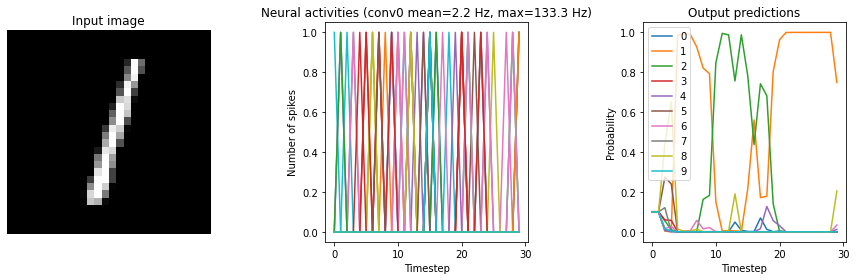

Scale=5


/home/viktor/.local/lib/python3.8/site-packages/nengo_dl/simulator.py:460: UserWarning: No GPU support detected. See https://www.nengo.ai/nengo-dl/installation.html#installing-tensorflow for instructions on setting up TensorFlow with GPU support.
  warnings.warn(


Test accuracy: 96.00%


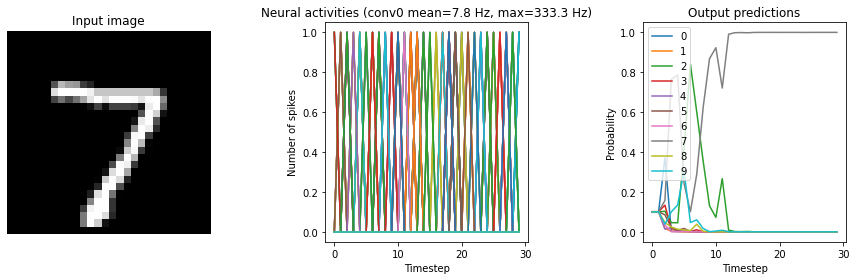

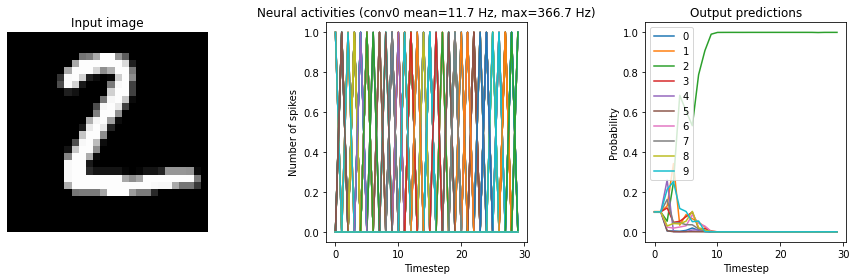

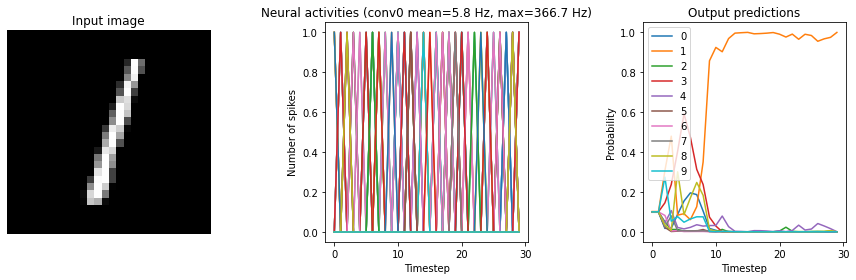

Scale=10


/home/viktor/.local/lib/python3.8/site-packages/nengo_dl/simulator.py:460: UserWarning: No GPU support detected. See https://www.nengo.ai/nengo-dl/installation.html#installing-tensorflow for instructions on setting up TensorFlow with GPU support.
  warnings.warn(


In [ ]:
for scale in [2, 5, 10]:
    print(f"Scale={scale}")
    run_network(
        activation=nengo.SpikingRectifiedLinear(),
        scale_firing_rates=scale,
        synapse=0.01,
    )
    plt.show()